In [63]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import operator
import os

In [95]:
# BASE_DIR='./outputs/second'
# BASE_DIR='./output-union'
# BASE_DIR='./bert/output-merged'
BASE_DIR='./output-parallel-subfamily'
SUBFAMILY_SIZE = 5

In [70]:
OUTPUT_DIR = "./plot_builder_output"
os.makedirs(f"{OUTPUT_DIR}/heatmaps", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/lineplot", exist_ok=True)

In [86]:
def load_results(benchmark, subfamily_size, method):
    with open(f"{BASE_DIR}/{benchmark}/{subfamily_size}/{method}.pickle", 'rb') as handle:
        result = pickle.load(handle)
    print(result)
    return result

In [87]:
def make_heatmap(results : dict, our_results : dict, title : str, baseline : str, minimizing = True, add_whole_family_value = True):
    values = np.array([list(item[-2].values()) for train, item in results.items()]).squeeze(axis=-1)
    values[~np.isfinite(values)] = np.nan
    # if add_whole_family_value:
        # entire_family_values = np.array([item[-1] for train, item in results.items()])
        # values = np.hstack([values, entire_family_values[..., None]])
    values = np.vstack([values, our_results['ours']])
    if add_whole_family_value:
        entire_family_values = np.array([item[-1] if item[-1] is not None else np.nan for train, item in results.items()] + [our_results['whole_family']])
        # entire_family_values[~np.isfinite(entire_family_values)] = np.nan
        values = np.hstack([values, entire_family_values[..., None]])
    plt.figure(figsize=(16,9))
    
    ax = sns.heatmap(values, annot=True, vmin=np.nanmin(values), vmax=np.nanmax(values), cmap=sns.cm.rocket_r if minimizing else sns.cm.rocket, mask=~np.isfinite(values), fmt='.2f')
    
    # if add_whole_family_value:
        # ax.add_patch(Rectangle((0,0), 10, 11, fill=False, edgecolor='white', lw=3)) # White bounding box
    
    subfamily_size = len(results.keys())
    
    best_value = np.inf if minimizing else -np.inf
    for r in range(values.shape[0]):
        row_values = values[r][:-1] if add_whole_family_value else values[r]
        idx = np.nanargmax(row_values) if minimizing else np.nanargmin(row_values)
        cmp = operator.le if minimizing else operator.ge
        if cmp(row_values[idx], best_value):
            best_value = row_values[idx]
            best_rectangle = (idx, r)
        ax.add_patch(Rectangle((idx, r),1,1, fill=False, edgecolor='blue', lw=3))
    ax.add_patch(Rectangle(best_rectangle,1,1, fill=False, edgecolor='green', lw=3))
    
    if add_whole_family_value:
        best_family_idx = np.nanargmin(values[:, -1]) if minimizing else np.nanargmax(values[:, -1])
        ax.add_patch(Rectangle((subfamily_size, best_family_idx),1,1, fill=False, edgecolor='green', lw=3))
    
    ax.set_xlabel("Test")
    ax.set_ylabel("Train")
    plt.yticks(rotation=0) 
    xticks = [f"{i}" for i in range(subfamily_size)]
    if add_whole_family_value:
        xticks += ["Entire family"]
    ax.set_xticklabels(xticks) 
    ax.set_yticklabels([f"{baseline} on {i} ({results[i][1].num_nodes}-FSC)" for i in range(subfamily_size)] + ["Ours: GD on (sub)family"])
    ax.set_title(f"{title}: {baseline} vs Ours ({'lower' if minimizing else 'higher'} is better)")
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/heatmaps/{title}-{baseline}.png")

In [88]:
import math
import random


def make_lineplot(results : dict, title : str = 'Placeholder', minimizing = True, type_of_plot = 'family_trace'):
    fig = plt.figure()
    ax = fig.gca()
    plt.title(f"{title} ({'lower' if minimizing else 'higher'} is better)")
    plt.xlabel("Iteration")
    plt.ylabel("Worst family member value")
    ax.plot(results['gd-normal'][type_of_plot], label='rfPG', color='green')
    
    min_x_normal = np.argmin(results['gd-normal'][type_of_plot]) if minimizing else np.argmax(results['gd-normal'][type_of_plot])
    min_y_normal = results['gd-normal'][type_of_plot][min_x_normal]
    
    # plt.plot(results['gd-no-momentum'][type_of_plot], label='rfPG (no momentum)', color='blue')
    # min_x_no_mom = np.argmin(results['gd-no-momentum'][type_of_plot]) if minimizing else np.argmax(results['gd-no-momentum'][type_of_plot])
    # min_y_no_mom = results['gd-no-momentum'][type_of_plot][min_x_no_mom]
    
    
    ax.plot(results['gd-random'][type_of_plot], label='Random rfPG',  color='red')
    
    min_x = np.argmin(results['gd-random'][type_of_plot]) if minimizing else np.argmax(results['gd-random'][type_of_plot])
    min_y = results['gd-random'][type_of_plot][min_x]
    
    # mini = min([min_x, min_x_normal, min_x_no_mom])
    # maxi = max([min_x, min_x_normal, min_x_no_mom])
    mini = min([min_x, min_x_normal])
    maxi = max([min_x, min_x_normal])
    
    def get(x):
        if math.isclose(mini, maxi) and math.isclose(x, maxi):
            return random.randint(-50, 50)
        elif math.isclose(x, maxi):
            return 50
        elif math.isclose(x, mini):
            return -50
        else:
            return 0
    
    ax.annotate(f"{min_y:.2f}",
            xy=(min_x, min_y), xycoords='data',
            xytext=(get(min_x), (50 if minimizing else -50)), textcoords='offset points',
            arrowprops=dict(facecolor='red', shrink=0),
            horizontalalignment='center', verticalalignment='bottom')
    
    ax.annotate(f"{min_y_normal:.2f}",
                xy=(min_x_normal, min_y_normal), xycoords='data',
                xytext=(get(min_x_normal), (50 if minimizing else -50)), textcoords='offset points',
                arrowprops=dict(facecolor='green', shrink=0),
                horizontalalignment='center', verticalalignment='bottom')
    
    # ax.annotate(f"{min_y_no_mom:.2f}",
    #     xy=(min_x_no_mom, min_y_no_mom), xycoords='data',
    #     xytext=(get(min_x_no_mom), (50 if minimizing else -50)), textcoords='offset points',
    #     arrowprops=dict(facecolor='blue', shrink=0),
    #     horizontalalignment='center', verticalalignment='bottom')
    
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/lineplot/{title}.png")
    plt.show()

In [73]:
ENVS = ['dpm', 'obstacles-10-2', 'avoid', 'obstacles-8-3', 'rover', 'network', 'obstacles-illustrative']
MINIMIZING = [False, True, True, True, False, False, True]

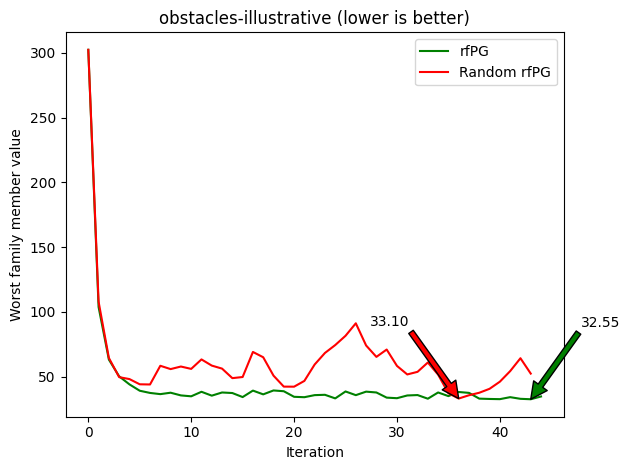

In [33]:
for env, minimizing in zip(ENVS, MINIMIZING):
    try:
        with open(f"{BASE_DIR}/{env}/gd-experiment.pickle", 'rb') as handle:
            results = pickle.load(handle)
            make_lineplot(results, title=env, minimizing=minimizing)
    except FileNotFoundError as fnfe:
        print(fnfe)

# DPM

timeout = 10s

In [9]:
dpm_our = [504.76099479, 496.6463078,  522.29707964, 471.26597349, 483.96767624,
 463.09737765, 294.67001291, 498.28841493, 510.35243059, 509.71750883]

In [10]:
with open(f"{BASE_DIR}/dpm/{SUBFAMILY_SIZE}/ours.pickle", 'rb') as handle:
    ours = pickle.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: './output-union/dpm/5/ours.pickle'

In [11]:
with open(f"{BASE_DIR}/dpm/{SUBFAMILY_SIZE}/saynt.pickle", 'rb') as handle:
    subfamily_saynt_results = pickle.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: './output-union/dpm/5/saynt.pickle'

In [ ]:
for i in range(SUBFAMILY_SIZE):
    fsc = subfamily_saynt_results[i][1]
    print(i, fsc.num_nodes)
    for j in range(fsc.num_nodes):
        print(fsc.update_function[j])

In [ ]:
with open(f"{BASE_DIR}/dpm/{SUBFAMILY_SIZE}/gradient.pickle", 'rb') as handle:
    subfamily_gd_results = pickle.load(handle)

In [ ]:
ours

In [ ]:
make_heatmap(subfamily_saynt_results, ours, "DPM", "Saynt", minimizing=False)

In [ ]:
make_heatmap(subfamily_gd_results, ours, "DPM", "GD", minimizing=False)

# OBSTACLES 8 3

timeout = 30s

In [ ]:
with open(f"{BASE_DIR}/obstacles-8-3/{SUBFAMILY_SIZE}/saynt.pickle", 'rb') as handle:
    saynt = pickle.load(handle)

In [ ]:
with open(f"{BASE_DIR}/obstacles-8-3/{SUBFAMILY_SIZE}/gradient.pickle", 'rb') as handle:
    gradient = pickle.load(handle)

In [ ]:
with open(f"{BASE_DIR}/obstacles-8-3/{SUBFAMILY_SIZE}/ours.pickle", 'rb') as handle:
    ours = pickle.load(handle)

In [ ]:
make_heatmap(saynt, ours, "OBSTACLES(8,3)", "Saynt")

## Gradient baseline

In [12]:
make_heatmap(gradient, ours, "OBSTACLES(8,3)", "GD")

NameError: name 'gradient' is not defined

# OBSTACLES 10 2

timeout = 10s

In [ ]:
with open(f"{BASE_DIR}/obstacles-10-2/{SUBFAMILY_SIZE}/ours.pickle", 'rb') as handle:
    ours = pickle.load(handle)

In [ ]:
with open(f"{BASE_DIR}/obstacles-10-2/{SUBFAMILY_SIZE}/saynt.pickle", 'rb') as handle:
    subfamily_saynt_results = pickle.load(handle)

In [ ]:
print("Obstacles(10, 2):")
for i in range(SUBFAMILY_SIZE):
    fsc = subfamily_saynt_results[i][1]
    print("POMDP", i, 'with a', f"{fsc.num_nodes}-FSC. Memory model:", fsc.memory_model)
    # for j in range(fsc.num_nodes):
        # print(fsc.update_function[j])
        # print("Node", j, [list(d.keys())[0] for d in fsc.update_function[j] if len(d) == 1])

In [ ]:
with open(f"{BASE_DIR}/obstacles-10-2/{SUBFAMILY_SIZE}/gradient.pickle", 'rb') as handle:
    subfamily_gd_results = pickle.load(handle)

In [ ]:
ours_raw = [27.85853738, 28.71888006, 30.78940948, 28.75065993, 29.3297606,  30.77959397,
 29.48840814, 29.3297606,  28.22878829, 30.14997737]

In [ ]:
ours

In [ ]:
make_heatmap(subfamily_saynt_results, ours, "OBSTACLES(10,2)", "Saynt")

In [ ]:
make_heatmap(subfamily_gd_results, ours, "OBSTACLES(10,2)", "GD")

# AVOID

timeout = 60s

In [31]:
with open(f"{BASE_DIR}/avoid/{SUBFAMILY_SIZE}/ours.pickle", 'rb') as handle:
    ours = pickle.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: './output-parallel-subfamily/avoid/1/ours-sparse.pickle'

In [ ]:
ours

In [ ]:
# with open(f"{BASE_DIR}/avoid/{SUBFAMILY_SIZE}/paynt.pickle", 'rb') as handle:
#     subfamily_paynt_results = pickle.load(handle)

In [ ]:
with open(f"{BASE_DIR}/avoid/{SUBFAMILY_SIZE}/gradient.pickle", 'rb') as handle:
    subfamily_gd_results = pickle.load(handle)

In [ ]:
with open(f"{BASE_DIR}/avoid/{SUBFAMILY_SIZE}/saynt.pickle", 'rb') as handle:
    subfamily_saynt_results = pickle.load(handle)

In [ ]:
for i in range(SUBFAMILY_SIZE):
    fsc = subfamily_gd_results[i][1]
    print(i, fsc.update_function)

In [ ]:
print("AVOID:")
for i in range(SUBFAMILY_SIZE):
    fsc = subfamily_saynt_results[i][1]
    print("POMDP", i, 'with a', f"{fsc.num_nodes}-FSC. Memory model:", fsc.memory_model)
    # for j in range(fsc.num_nodes):
        # print(fsc.update_function[j])
        # print("Node", j, [list(d.keys())[0] for d in fsc.update_function[j] if len(d) == 1])

In [ ]:
l = [51.94674404, 65.42364497, 63.76348781, 98.68745545, 32.52550974, 67.09607064,
 87.41523619, 64.81453459, 53.95332456, 56.50783793]

In [ ]:
make_heatmap(subfamily_saynt_results, ours, "AVOID", "Saynt")

In [ ]:
# make_heatmap(subfamily_paynt_results, ours, "AVOID", "Paynt")

In [ ]:
make_heatmap(subfamily_gd_results, ours, "AVOID", "GD")

# UNIONS

In [ ]:
# ENVS = ['dpm', 'network', 'obstacles-8-3', 'obstacles-10-2', 'rover']

for env, minimizing in zip(ENVS, MINIMIZING):
    if 'avoid' in env.lower(): continue
    values = np.zeros((1, 11))
    # print(env)
    with open(f"{BASE_DIR}/{env}/union/union.pickle", 'rb') as handle:
        results = pickle.load(handle)
    values[0, :-1] = results['subfamily']
    values[0, -1]  = results['whole_family']

    print(env, results['subfamily'], max(results['subfamily']) if minimizing else min(results['subfamily']), results['whole_family'], sep='\n')
    # plt.figure()
    # sns.heatmap(values, yticklabels=[env], annot=True, vmin=np.nanmin(values), vmax=np.nanmax(values), cmap=sns.cm.rocket_r if minimizing else sns.cm.rocket, mask=~np.isfinite(values), fmt='.2f')
    # plt.show()

# obstacles-illustrative

In [105]:
benchmark = "obstacles-illustrative"
SUBFAMILY_SIZE =  4

In [106]:
ours = load_results(benchmark, subfamily_size, "ours-sparse")
subfamily_gd_results = load_results(benchmark, subfamily_size, "gradient")
subfamily_saynt_results = load_results(benchmark, subfamily_size, "saynt")

{'ours': array([18.22837795, 19.07202978, 19.15455753,  9.79989135]), 'whole_family': 19.15455753022259, 'fsc': <paynt.quotient.fsc.FSC object at 0x708d40076bc0>}
{0: ('ox_init=3, oy_init=2', <paynt.quotient.fsc.FSC object at 0x708d4010d990>, {0: [19.94138135146185], 1: [55.66973817220132], 2: [67.63230847233363], 3: [25.13149655807973]}, 67.63230847233363), 1: ('ox_init=3, oy_init=3', <paynt.quotient.fsc.FSC object at 0x708d400f9570>, {0: [53.10391210133039], 1: [26.482030084320208], 2: [38.682853664503234], 3: [62.07871074985467]}, 62.07871074985467), 2: ('ox_init=2, oy_init=3', <paynt.quotient.fsc.FSC object at 0x708d400fb520>, {0: [3898.587349506843], 1: [700.2514239124757], 2: [16.786096869137584], 3: [12.458003799024405]}, 3898.587349506843), 3: ('ox_init=2, oy_init=2', <paynt.quotient.fsc.FSC object at 0x708d400f9e40>, {0: [17.60143807516643], 1: [317.73755859445583], 2: [2434.6112168849854], 3: [7.381495436887123]}, 2434.6112168849854)}
{0: ('ox_init=3, oy_init=2', <paynt.quoti

In [107]:
for i in range(SUBFAMILY_SIZE):
    fsc = subfamily_gd_results[i][1]
    print(i, fsc.update_function)

0 [[{0: 0.27466067634012253, 1: 0.6161917868948834, 2: 0.10914753676499413}, {0: 0.8971664131995313, 1: 0.08438195667922838, 2: 0.018451630121240372}, {0: 0.08848927105634098, 1: 0.778256191966274, 2: 0.133254536977385}, {0: 0.03275536462838502, 1: 0.9247234758063593, 2: 0.042521159565255665}, {0: 0.3805059340774514, 1: 0.12380869166424831, 2: 0.4956853742583001}, {0: 0.3333333333333333, 1: 0.3333333333333333, 2: 0.3333333333333333}], [{0: 0.27466067634012253, 1: 0.6161917868948834, 2: 0.10914753676499413}, {0: 0.36472023104697415, 1: 0.5539420389004328, 2: 0.08133773005259316}, {0: 0.007184423486109662, 1: 0.9752783650043553, 2: 0.017537211509534984}, {0: 0.03275536462838502, 1: 0.9247234758063593, 2: 0.042521159565255665}, {0: 0.3805059340774514, 1: 0.12380869166424831, 2: 0.4956853742583001}, {0: 0.3333333333333333, 1: 0.3333333333333333, 2: 0.3333333333333333}], [{0: 0.27466067634012253, 1: 0.6161917868948834, 2: 0.10914753676499413}, {0: 0.012828235619357304, 1: 0.0133710763157318

In [108]:
print(f"{benchmark} :")
for i in range(SUBFAMILY_SIZE):
    fsc = subfamily_saynt_results[i][1]
    print("POMDP", i, 'with a', f"{fsc.num_nodes}-FSC. Memory model:", fsc.memory_model)
    # for j in range(fsc.num_nodes):
        # print(fsc.update_function[j])
        # print("Node", j, [list(d.keys())[0] for d in fsc.update_function[j] if len(d) == 1])

obstacles-illustrative :
POMDP 0 with a 3-FSC. Memory model: [1, 3, 3, 1, 1]
POMDP 1 with a 3-FSC. Memory model: [1, 3, 3, 1, 1, 1]
POMDP 2 with a 3-FSC. Memory model: [1, 3, 3, 1, 1]
POMDP 3 with a 2-FSC. Memory model: [1, 2, 2, 1, 1]


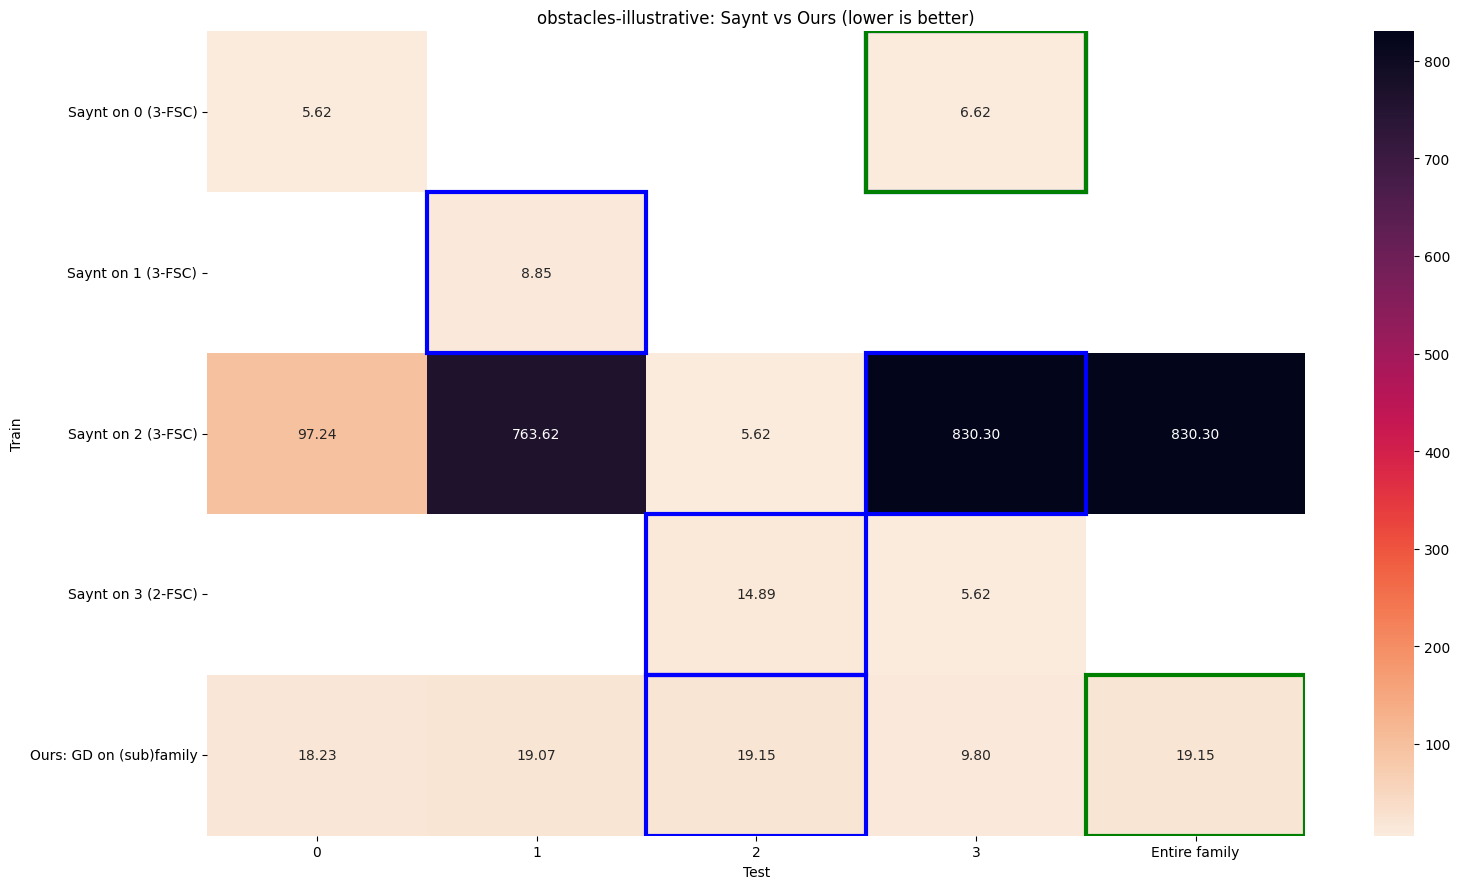

In [109]:
make_heatmap(subfamily_saynt_results, ours, benchmark, "Saynt")

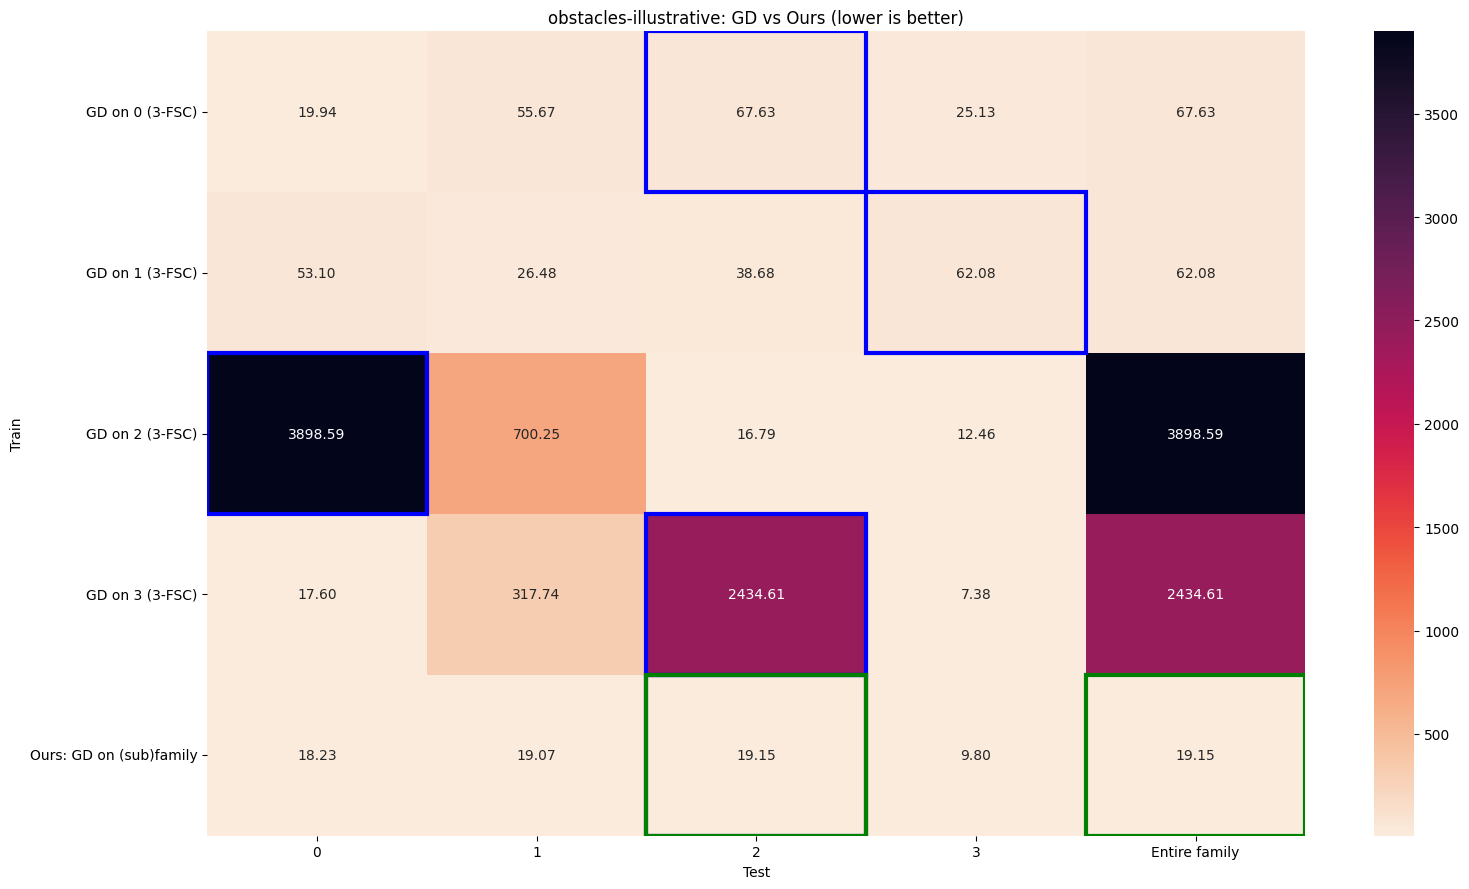

In [110]:
make_heatmap(subfamily_gd_results, ours, benchmark, "GD")